In [1]:
import numpy as np
import matplotlib.pyplot as plt

import warnings

# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)


Consider solving the following initial-boundary value problem
$$  \frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}, \qquad (x,t) \in (0,L)\times(0,T]  $$
where the initial value is given by
$$  u(x,0) = I(x), \quad u(0,0)=u_0, \quad u(L,0) = u_L  $$


In [113]:
T = 20
L = 10
dx = 0.1
dt = 0.001
alpha = 1
F = alpha*dt/dx**2

xList = np.arange(0,L,dx)
tList = np.arange(0,T,dt)
N_x = xList.shape[0]
N_t = tList.shape[0]

u_0 = 0
u_L = 0

X,T = np.meshgrid(xList,tList)



In [42]:
def I(x):
    # sigma = 1
    # mean = L/2
    # return np.exp(-0.5*((x-mean)/sigma)**2)fd
    results = np.ones(x.shape)
    results[:4*N_x//10] = 0
    results[6*N_x//10:] = 0
    return results
    


def f(x,t):
    # mean = L / 2
    # sigma = L / 100
    # return np.exp(-0.5 * ((x - mean) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi)) * np.exp(-t/10)
    # return 10*alpha*t + 5*x*(L-x)
    return 0*x


def u(x,t):
    return 5*t*x*(L-x)


## Explicit Euler Method

In [43]:
computedList = np.zeros((xList.shape[0],tList.shape[0]))
computedList[:,0] = I(xList)
computedList[0,0] = u_0
computedList[-1,0] = u_L
for i in range(1,N_t):
    computedList[1:N_x-1,i] = computedList[1:N_x-1,i-1] \
    + alpha*dt/(dx)**2 * (computedList[2:N_x,i-1] - 2* computedList[1:N_x-1,i-1] + computedList[0:N_x-2,i-1]) \
    + f(xList[1:N_x-1],tList[i]) * dt

    computedList[0,i] = u_0
    computedList[-1,i] = u_L

    

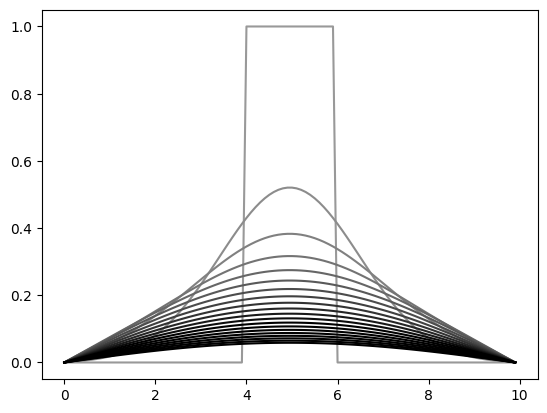

In [44]:
numberOfLines = 20
num_shades = numberOfLines
cmap = plt.get_cmap('gray')
colors = [cmap((i) / num_shades-0.35) for i in range(num_shades)]

for i in range(numberOfLines):
    plt.plot(xList,computedList[:,i*N_t//numberOfLines],color=colors[-i-1])
    


## Implicit Euler Method

In [45]:
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve


In [46]:
mainDiag = np.ones(N_x)*(1+2*F); mainDiag[0] = 1; mainDiag[-1] = 1
lowerDiag = np.ones(N_x-1)*(-F); lowerDiag[-1] = 0
upperDiag = np.ones(N_x-1)*(-F); upperDiag[0] = 0

diagonals = [lowerDiag, mainDiag, upperDiag]; offsets = [-1, 0, 1]
A = diags(diagonals, offsets).tocsc()

In [47]:
computedList = np.zeros((xList.shape[0],tList.shape[0]))
computedList[:,0] = I(xList)
computedList[0,0] = u_0
computedList[-1,0] = u_L
for i in range(1,N_t):
    F_RHS = f(xList,tList[i])*dt; F_RHS[-1]=0; F_RHS[0]=0
    b = computedList[:,i-1] + F_RHS
    computedList[:,i] = spsolve(A, b)


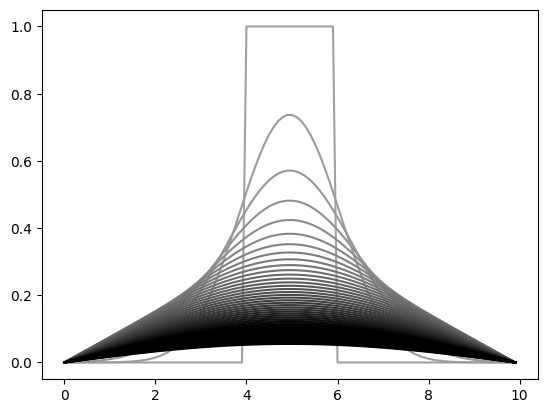

In [48]:
numberOfLines = 50
num_shades = numberOfLines
cmap = plt.get_cmap('gray')
colors = [cmap((i) / num_shades-0.35) for i in range(num_shades)]

for i in range(numberOfLines):
    plt.plot(xList,computedList[:,i*N_t//numberOfLines],color=colors[-i-1])
    


## Crank–Nicolson method
The approximated PDE is
$$  [D_t u = \alpha D_x D_x u + f]_i^{n+1/2}  $$
Which is a compact form of 
$$  \frac{u_i^{n+1/2} - u_i^{n-1/2}}{\Delta t} = \frac{\alpha}{\Delta x^2}(u_{i+1}^{n+1/2} - 2u_{i}^{n+1/2} + u_{i-1}^{n+1/2}) + f_i^{n+1/2} $$
By approximating the mid time step values by the average of neighbor time steps values, i.e. for instance $ u^{n+1/2} = 1/2(u^n + u^{n+1}) $ we will get
$$ u_{i}^{n+1} - \frac{F}{2}(u_{i+1}^{n+1} - 2u_i^{n+1} + u_{i-1}^{n+1}) = u_i^n  + \frac{F}{2}(u_{i+1}^n - 2u_{i}^n + u_{i-1}^n) + 1/2(f_i^n + f_i^{n+1})\Delta t $$



In [115]:
mainDiag = np.ones(N_x)*(1+F); mainDiag[0] = 1; mainDiag[-1] = 1
lowerDiag = np.ones(N_x-1)*(-F/2); lowerDiag[-1] = 0
upperDiag = np.ones(N_x-1)*(-F/2); upperDiag[0] = 0

diagonals = [lowerDiag, mainDiag, upperDiag]; offsets = [-1, 0, 1]
A = diags(diagonals, offsets).tocsc()

mainDiag = np.ones(N_x)*(1-F); mainDiag[0] = 1; mainDiag[-1] = 1
lowerDiag = np.ones(N_x-1)*(F/2); lowerDiag[-1] = 0
upperDiag = np.ones(N_x-1)*(F/2); upperDiag[0] = 0

diagonals = [lowerDiag, mainDiag, upperDiag]; offsets = [-1, 0, 1]
B = diags(diagonals, offsets).tocsc()

mainDiag = np.ones(N_x)*1/2; mainDiag[0]=0; mainDiag[-1]=0
upperDiag = np.ones(N_x-1)*1/2; upperDiag[0] = 0;

diagonals = [mainDiag, upperDiag]; offsets = [0, 1]
FMat = diags(diagonals, offsets).tocsc()

In [116]:
computedList = np.zeros((xList.shape[0],tList.shape[0]))
computedList[:,0] = I(xList)
computedList[0,0] = u_0
computedList[-1,0] = u_L
for i in range(1,N_t):
    b = B.dot(computedList[:,i-1]) + FMat.dot(f(xList,tList[i]))
    computedList[:,i] = spsolve(A, b)

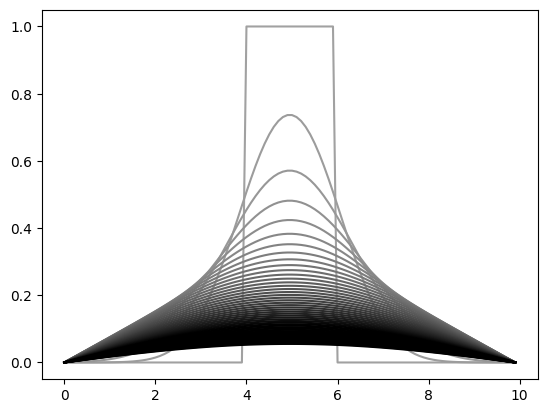

In [118]:
numberOfLines = 50
num_shades = numberOfLines
cmap = plt.get_cmap('gray')
colors = [cmap((i) / num_shades-0.35) for i in range(num_shades)]

for i in range(numberOfLines):
    plt.plot(xList,computedList[:,i*N_t//numberOfLines],color=colors[-i-1])





# 2D Diffusion

# Index mapping experiment

In [2]:
class Tau:
    def __init__(self):
        self.vectors = [np.array([0,1]),np.array([1,0]),np.array([0,-1]),"stall"]
    def __mul__(self, b):
        return b

    def __pow__(self,n):
        return tau

    def __getitem__(self,i):
        return self.vectors[i]

class Sigma_1:
    def __init__(self):
        self.vectors = [np.array([1,0]),np.array([0,1]),np.array([-1,0]),"stall"]
        
    def __mul__(self, b):
        if b == tau:
            return sigma_1
        if b == sigma_1:
            return tau
        if b == sigma_2:
            return sigma_3
        if b == sigma_3:
            return sigma_2
            
    def __getitem__(self,i):
        return self.vectors[i]
        
    def __pow__(self,n):
        if n == 0:
            return tau
        result = sigma_1
        for i in range(n-1):
            result *= sigma_1
        return result


class Sigma_2:
    def __init__(self):
        self.vectors = [np.array([-1,0]),np.array([0,-1]),np.array([1,0]),"stall"]
        
    def __mul__(self, b):
        if b == tau:
            return sigma_2
        if b == sigma_1:
            return sigma_3
        if b == sigma_2:
            return tau
        if b == sigma_3:
            return sigma_1

    def __getitem__(self,i):
        return self.vectors[i]

    def __pow__(self,n):
        if n == 0:
            return tau
        result = sigma_2
        for i in range(n-1):
            result *= sigma_2
        return result
        

class Sigma_3:
    def __init__(self):
        self.vectors = [np.array([0,-1]),np.array([-1,0]),np.array([0,1]),"stall"]
    def __getitem__(self,i):
        return self.vectors[i]
    def __mul__(self, b):
        if b == tau:
            return sigma_3
        if b == sigma_1:
            return sigma_2
        if b == sigma_2:
            return sigma_1
        if b == sigma_3:
            return tau


def base4(number, degree):
    result = [0 for i in range(degree)]
    for i in range(degree):
        result[-i-1]=number%4
        number = number//4

    return result


def generateHilbertCurve(d):
    
    init = sigma_1**(d)
    origin = np.array([0,0])
    orderedGuiderList = [sigma_1,tau,tau,sigma_2]
    positionsList = []
    positionsList.append(np.copy(origin))
    endFlag = 0
    for i in range(4**d):
        ID = base4(i,d) ## for instance ID = [1,3,2] when degree=3
        currentMoveGuideList = [] ## for example moveGuide=[tau,sigma_1,tau] for d=3
        currentMoveGuideList.append(tau)
        counter = 0
        for base4ID in ID[:-1]:
            currentMoveGuideList.append((currentMoveGuideList[-1])*orderedGuiderList[base4ID])
            counter += 1
    
        counter = 0
        mover = currentMoveGuideList[-1-counter]
        while mover[ID[-1-counter]] == "stall":
            counter += 1
            if (counter == d):
                endFlag = 1
                break
            mover = currentMoveGuideList[-1-counter]
    
        # print(mover[ID[-1-counter]])
        if (endFlag == 0):
           origin += mover[ID[-1-counter]] 
            
        positionsList.append(np.copy(origin))
    
    
    
        
    positionsList = np.array(positionsList)
    return positionsList




sigma_1 = Sigma_1()
sigma_2 = Sigma_2()
sigma_3 = Sigma_3()
tau = Tau()

In [3]:
def isBoundary(i,j):
    if (i < 0 or j < 0 or i>=N_x or j>=N_y):
        print("Out of domain")
        return False
    detector = ((i == N_x -1) or (i==0)) or ((j==N_y-1) or (j==0))
    if (detector):
        return True
    else:
        return False

def indexMapping_standard(i,j):
     return j*(N_x) + i



def indexMapping_diag(i,j):
    '''
    For a 4 * 4 grid
    0,1,2,3 --> for the elements on y=x
    4,5,6 --> for the elements on y=x-1
    7,8,9 --> for the elements on y=x+1
    10,11 --> for the elements on y=x-2
    12,13 --> for the elements on y=x+2
    14    --> for the elements on y=x-3
    15    --> for the elements on y=x+3
    '''
    offDiagIndex = i-j
    if offDiagIndex == 0:
        return i
    else:
        offSet = 0 + N_x
        for ind in range(1,np.abs(offDiagIndex)):
            offSet += 2*(N_x-ind)
        if offDiagIndex < 0:
            offSet += (N_x-np.abs(offDiagIndex))
            return offSet + i
        else:
            return offSet + j
        
        

def indexMapping_Hilbert(i,j):
    input_value = [i,j]
    
    # Finding the row number
    row_index = np.where((posList == input_value).all(axis=1))[0]
    
    return row_index[0]

        

In [6]:
def generateNeighborhoodMatrix(indexMapping):
    mat = np.zeros((N_x*N_y,N_x*N_y)) 
    for j in range(N_y):
        for i in range(N_x):
            rowIndex = indexMapping(i,j)
            mat[rowIndex,rowIndex] = 1
            if isBoundary(i,j):
                continue
            else:
                mat[indexMapping(i,j),indexMapping(i+1,j)] = 1
                mat[indexMapping(i,j),indexMapping(i-1,j)] = 1
                mat[indexMapping(i,j),indexMapping(i,j-1)] = 1
                mat[indexMapping(i,j),indexMapping(i,j+1)] = 1
    return mat

def goodMatrix(indexMapping):
    grid = np.zeros((N_x, N_y), dtype=int)
    backGround = grid*0 + 1
    
    
    
    # Fill the grid with indices
    for j in range(N_y):
        for i in range(N_x):
            grid[i, j] = indexMapping(i,j)
    
    # Plot the grid using imshow
    fig, ax = plt.subplots()
    cax = ax.imshow(backGround,origin="lower")
    
    
    # Add the index numbers to the grid
    for j in range(N_y):
        for i in range(N_x):
            ax.text(i,j, f'{grid[i, j]}', ha='center', va='center', fontsize=10, color='white')
    
    # Add grid lines
    ax.set_xticks(np.arange(-0.5, N_x, 1))
    ax.set_yticks(np.arange(-0.5, N_x, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(which="both", color="white", linestyle='-', linewidth=2)
    
    plt.show()

            

In [31]:
degree = 6
posList = generateHilbertCurve(degree)
posList = posList.astype("float")
N_x = 2**degree
N_y = 2**degree
func = indexMapping_Hilbert
mat = generateNeighborhoodMatrix(func)
# goodMatrix(func)

(-3.1500000000000004, 66.15, -3.1500000000000004, 66.15)

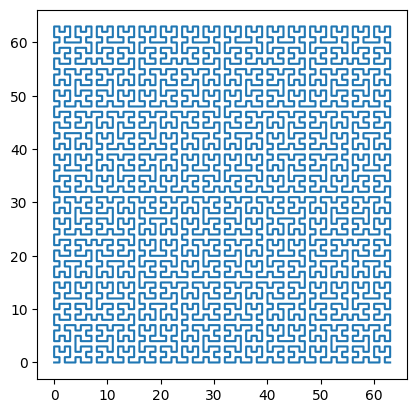

In [32]:
plt.plot(posList[:,0],posList[:,1])
plt.axis("square")

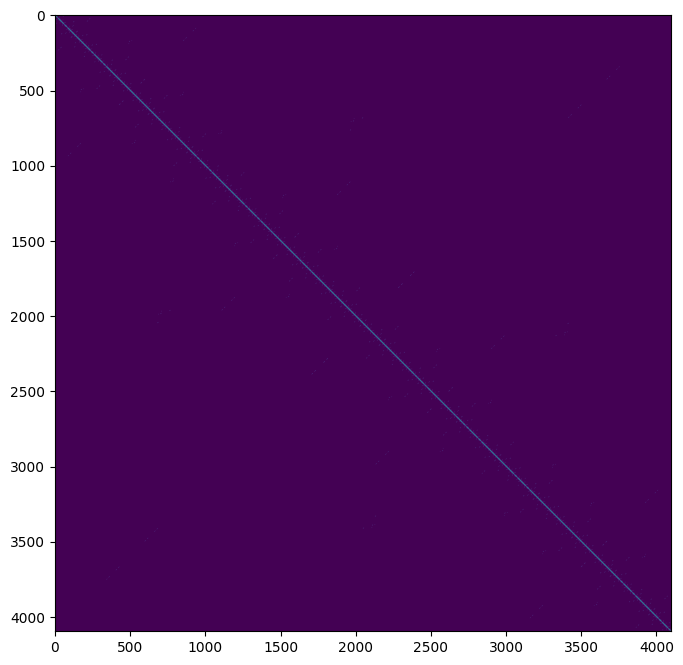

In [33]:
### Turining a matrix into a column vector by opening it according to a Hilbert Curve running through the elements
plt.figure(figsize=(8,8))
plt.imshow(mat,origin="upper")

In [333]:
# fig = plt.figure(figsize=(10,10))
# # posList += np.random.rand(*posList.shape)*0.7

# # Iterate over each row and multiply by a different random 2x2 matrix
# for i in range(posList.shape[0]):
#     # random_matrix = np.eye(2) + np.random.randn(2, 2)*0.004
#     randomAngle = np.random.randn(1)[0] * 0.01
#     random_matrix = np.array([[1,-randomAngle],[randomAngle,1]])
#     posList[i] += (posList[i])/(0.01+np.linalg.norm(posList[i])) @ random_matrix  # Matrix multiplication for each row


# plt.plot(posList[:,0],posList[:,1])
# _=plt.axis("square")